<a href="https://colab.research.google.com/github/doeungim/ADP_DE/blob/main/ADP_Exam2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

USER_0598e198

In [1]:
from IPython.display import display, HTML
display(HTML('<style>.container {width:98% !important;}</style>'))

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import platform
if platform.system()=='Windows':
    plt.rc('font',family='Malgun Gothic')
elif platform.system()=='Linux':
    plt.rc('font',family='Malgun Gothic')
plt.rcParams['axes.unicode_minus']=False

import pandas as pd
pd.set_option('display.max_columns',200)
import numpy as np
import seaborn as sns
import datetime as dt

import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error

from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMClassifier, LGBMRegressor

In [2]:
# 한글 꺠짐 필요 라이브러리 불러오기
import matplotlib.font_manager as fm
import os
import matplotlib.pyplot as plt

# apt-get : 패키지 설치 명령어
# -qq : 에러외의 메세지 숨기는 옵션키
!apt-get -qq install fonts-nanum


fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 8, 'font.family': 'NanumGothic'}) # 폰트 설정

Selecting previously unselected package fonts-nanum.
(Reading database ... 123597 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/mock/002_m1.csv')
df.sample(5)

,사업장명,업태구분명,진료과목내용명,도로명전체주소,인허가일자,상세영업상태명,폐업일자
68682,용산이비인후과의원,의원,이비인후과,대구광역시 달서구 용산로 225 (용산동),2000-02-15,폐업,2016-09-12
10046,더플란트치과의원,치과의원,치과,"대구광역시 수성구 동대구로 311, 13층 (범어동, 범어 애플타워)",2009-06-26,영업중,NaN
35066,365다찬한의원,한의원,"한방내과, 한방부인과, 한방소아과, 한방안·이비인후·피부과, 한방신경정신과, 한방재...","경기도 수원시 영통구 영통로214번길 64, 6층 (영통동)",2020-03-12,영업중,NaN
35322,서의원,의원,마취통증의학과,"경기도 고양시 덕양구 중앙로 550, 삼일프라자 602호호 (행신동)",2018-10-16,영업중,NaN
2431,키즈위즈 소아청소년과의원,의원,소아청소년과,"서울특별시 송파구 올림픽로 435 (신천동, 상가A동 504호)",2009-01-08,영업중,NaN


In [4]:
# 결측치 확인
df.isna().sum().to_frame().T

,사업장명,업태구분명,진료과목내용명,도로명전체주소,인허가일자,상세영업상태명,폐업일자
0,0,0,0,0,0,0,66056


In [5]:
# 데이터 전처리
df['인허가일자'] = pd.to_datetime(df['인허가일자'], format = '%Y-%m-%d')
df['폐업일자'] = pd.to_datetime(df['폐업일자'], format = '%Y-%m-%d')
df['광역시'] = df['도로명전체주소'].str.split(' ').str[0]


<Axes: xlabel='업태구분명', ylabel='광역시'>

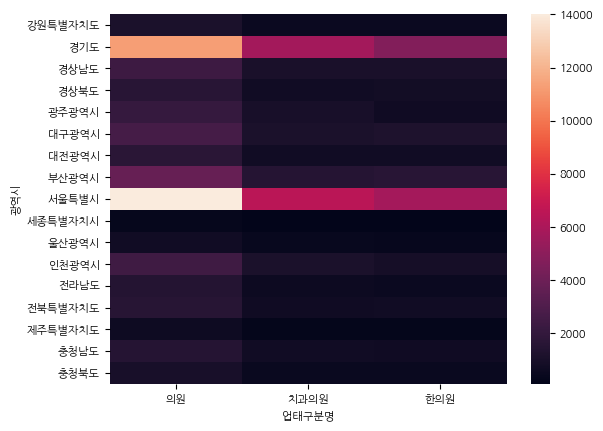

In [6]:
## 데이터 시각화
sns.heatmap(pd.crosstab(df['광역시'],df['업태구분명']))

<Axes: xlabel='허가년도', ylabel='count'>

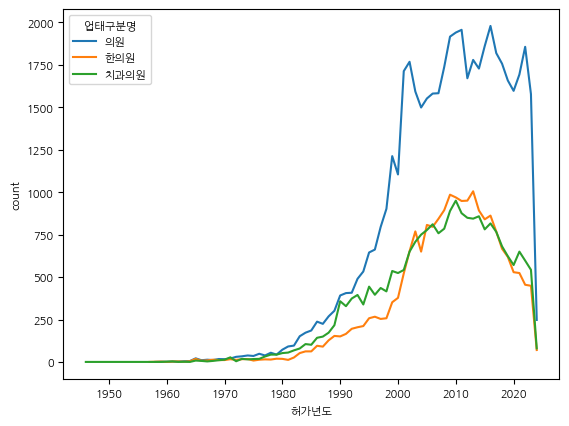

In [7]:
df['허가년도'] = df['인허가일자'].dt.year

target = df[['허가년도','업태구분명']].value_counts().reset_index(name = 'count')
sns.lineplot(x = '허가년도', y = 'count', hue = '업태구분명', data = target)

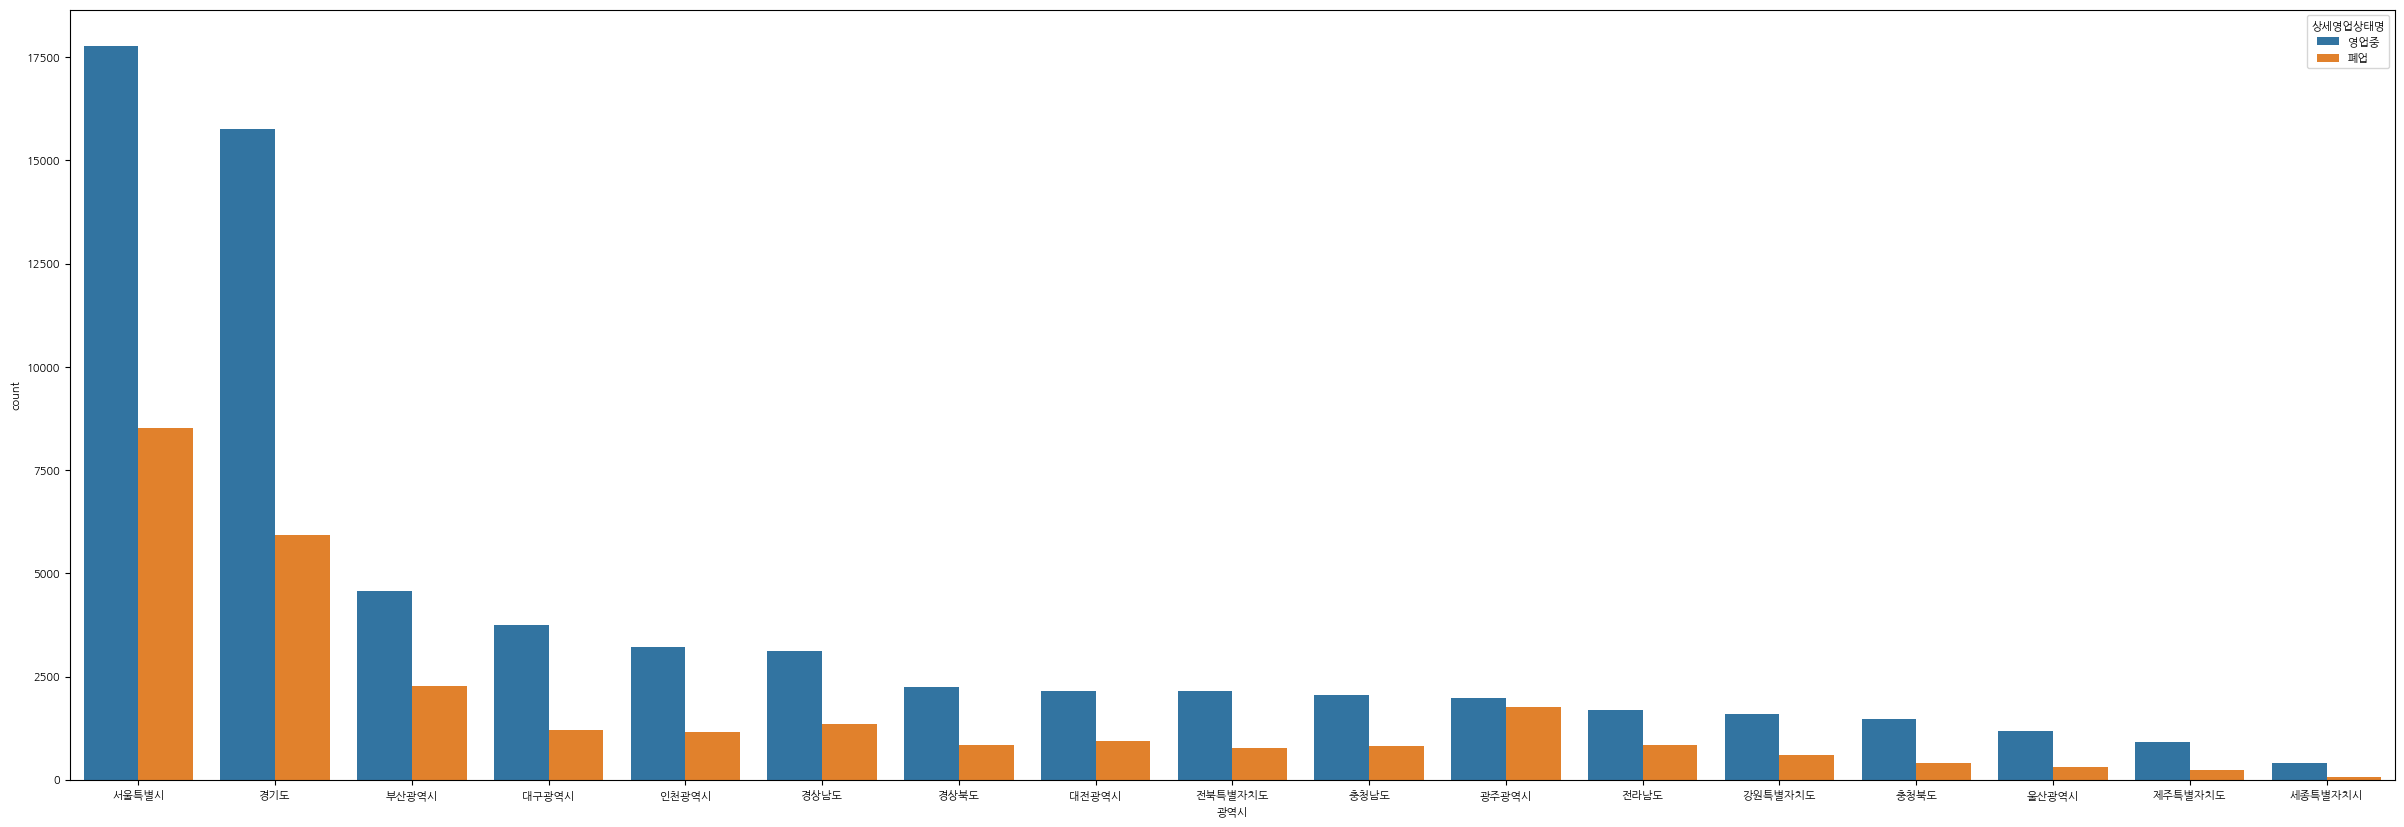

In [8]:
fig, ax = plt.subplots(figsize=(30, 10))  # Create a figure and axes object
target = df[['광역시','상세영업상태명']].value_counts().reset_index(name='count')
sns.barplot(x='광역시', y='count', hue='상세영업상태명', data=target, ax=ax)  # Plot the data on the axes
plt.show()

1-2 진료과목내용명의 연관분석을 진행하려한다. 업태를 의원,한의원,치과의원 각각 나누어 데이터 전처리 및 트랜잭션 변환을 진행하라

In [9]:
df['Split'] = df['진료과목내용명'].map(lambda x : [y.strip() for y in x.split(',')])
df['ID'] = ['ID_' + str(x) for x in range(len(df))]

#  explode 함수는 하나의 셀에 리스트 형태로 저장된 값들을 여러 행으로 나누어 각각의 값을 독립적인 행으로 만드는 데 사용되는 함수
def preprocessing (df) :
  f = df[['ID', 'Split']].explode('Split').reset_index(drop = True)
  ff = f.explode('Split')
  tr =ff.pivot_table(index = 'ID', columns = 'Split', aggfunc = len).fillna(0).astype('int')
  tr  = tr >= 1
  return tr

In [10]:
# 문자열이 , 로 되어있기 때문에 구분시킨다.

def lst_transform(df) :
  df_split = df['진료과목내용명'].str.split(', ', expand=True)
  df_split_ary = df_split.values

  lst = []
  for i in range(len(df_split_ary)):
      temp = list(filter(lambda x: x is not None, df_split_ary[i]))
      lst.append(temp)
  return lst


In [11]:
# None를 지우고 트랜잭션 형태로 바꿀 수 있게 데이터 list 변환
df1 = lst_transform(df[df['업태구분명'] == '치과의원'])
df2 = lst_transform(df[df['업태구분명'] == '한의원'])
df3 = lst_transform(df[df['업태구분명'] == '의원'])

In [12]:
from mlxtend.preprocessing import TransactionEncoder

def transaction(lst) :
  te = TransactionEncoder()
  tr_df = pd.DataFrame(te.fit(lst).transform(lst), columns = te.columns_)
  return tr_df

tr_df1 = transaction(df1)
tr_df2 = transaction(df2)
tr_df3 = transaction(df3)

기계학습3
- 업태별로 연관 규칙 생성 및 평가 지표 계산을 진행하라

In [13]:
from mlxtend.frequent_patterns import apriori , association_rules

def rules_df(df):
  fr = apriori(df, min_support = 0.1, use_colnames = True)
  ## assocation_rules 함수로 규칙 생성
  rules = association_rules(fr, metric = "confidence", min_threshold= 0.1)
  rules['antecedents_str'] = rules['antecedents'].map(lambda x : len(x))
  rules['consequents_str'] = rules['consequents'].map(lambda x : len(x))
  rules = rules[['antecedents','consequents','support','confidence','lift']]
  rules = rules.sort_values('support', ascending = False)
  return rules

print("치과의원")
display(rules_df(tr_df1).head(10))

print("한의원")
display(rules_df(tr_df2).head(10))

print("의원")
display(rules_df(tr_df3).head(10))


치과의원


,antecedents,consequents,support,confidence,lift
103,(치주과),(치과보철과),0.433924,0.978846,2.167926
102,(치과보철과),(치주과),0.433924,0.961045,2.167926
97,(치과보존과),(치과보철과),0.425238,0.981742,2.174341
96,(치과보철과),(치과보존과),0.425238,0.941807,2.174341
98,(치과보존과),(치주과),0.423768,0.978350,2.206962
99,(치주과),(치과보존과),0.423768,0.955937,2.206962
1021,"(치과보철과, 치주과)",(치과보존과),0.419058,0.965740,2.229595
1020,"(치과보철과, 치과보존과)",(치주과),0.419058,0.985467,2.223018
1025,(치주과),"(치과보철과, 치과보존과)",0.419058,0.945311,2.223018
1024,(치과보존과),"(치과보철과, 치주과)",0.419058,0.967475,2.229595


한의원


,antecedents,consequents,support,confidence,lift
26,(한방내과),(한방부인과),0.909586,0.918377,1.005422
27,(한방부인과),(한방내과),0.909586,0.995798,1.005422
29,(한방소아과),(한방내과),0.902194,0.995764,1.005387
28,(한방내과),(한방소아과),0.902194,0.910913,1.005387
36,(한방소아과),(한방부인과),0.897218,0.990272,1.084131
37,(한방부인과),(한방소아과),0.897218,0.982258,1.084131
15,(침구과),(한방내과),0.896223,0.995002,1.004618
14,(한방내과),(침구과),0.896223,0.904885,1.004618
274,"(한방부인과, 한방소아과)",(한방내과),0.893807,0.996197,1.005825
272,"(한방내과, 한방소아과)",(한방부인과),0.893807,0.990703,1.084603


의원


,antecedents,consequents,support,confidence,lift
12,(소아청소년과),(내과),0.369983,0.913942,1.611779
13,(내과),(소아청소년과),0.369983,0.652483,1.611779
25,(피부과),(내과),0.324234,0.684855,1.207774
24,(내과),(피부과),0.324234,0.571802,1.207774
19,(이비인후과),(내과),0.277984,0.871315,1.536604
18,(내과),(이비인후과),0.277984,0.490238,1.536604
44,(소아청소년과),(이비인후과),0.263282,0.650367,2.038513
45,(이비인후과),(소아청소년과),0.263282,0.825234,2.038513
49,(피부과),(소아청소년과),0.258569,0.546155,1.349126
48,(소아청소년과),(피부과),0.258569,0.638724,1.349126


In [14]:
print("""
치과 :
  치주, 치과보철, 치과보존과의 관계가 높은 것으로 판단
  전략) 단순 진료의 치과보다는 종합 치과 서비스나 치주 질환 및 치아보존관련 전문 업종의 전문 서비스 제공

의원
  소아청소년과, 내과의 신뢰도가 높은 지지도와 향상도를 보여준다. 두 업태의 신뢰도를 해석해보면, 소아 청소년과에 가지 못할 경우
  내과에 가는 비율이 상당이 높다는 것을 알 수 있다. 또 한, 내과는 피부과와도 높은 지지도를 보이기 때문에, 내과를 기반으로,
  소아청소년 진단 및 피부과 진료를 함께 제공하면 모든 연령대에 맞는 타켓이 될 수 있을 것 이다.

한의원
  한의원의 경우, 내과, 부인과, 소와과 등 업체에국한되지 않게 각 항목집단별 지지도가 골고루 높다. 특정 업태를 타켓팅 하는 것보다
  통합 진료 서비스을 제공하는 것이 적절해 보인다.
""")


치과 : 
  치주, 치과보철, 치과보존과의 관계가 높은 것으로 판단 
  전략) 단순 진료의 치과보다는 종합 치과 서비스나 치주 질환 및 치아보존관련 전문 업종의 전문 서비스 제공 

의원 
  소아청소년과, 내과의 신뢰도가 높은 지지도와 향상도를 보여준다. 두 업태의 신뢰도를 해석해보면, 소아 청소년과에 가지 못할 경우
  내과에 가는 비율이 상당이 높다는 것을 알 수 있다. 또 한, 내과는 피부과와도 높은 지지도를 보이기 때문에, 내과를 기반으로, 
  소아청소년 진단 및 피부과 진료를 함께 제공하면 모든 연령대에 맞는 타켓이 될 수 있을 것 이다. 

한의원 
  한의원의 경우, 내과, 부인과, 소와과 등 업체에국한되지 않게 각 항목집단별 지지도가 골고루 높다. 특정 업태를 타켓팅 하는 것보다 
  통합 진료 서비스을 제공하는 것이 적절해 보인다. 



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## 서울의 미세먼지 데이터

- 2020년~ 2022년도의 서울 각 지역구의 시간별
- 미세먼지(pm10)와 초미세먼지(pm25)데이터이다.
- 하루동안의 미세먼지(pm10)와 지역구,시간 정보를 바탕으로 다음날 00:00시의 해당 지역구의 초미세먼지(pm25)를 예측하는 회귀 모델을 만들려고 한다.

In [15]:
import pandas as pd
df = pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/mock/002_m2.csv')
df.head(10)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,일시,구분,pm10,pm25,date,hour
0,2022-12-31 23:00:00,강남구,57.0,44.0,2022-12-31,23
1,2022-12-31 23:00:00,강동구,68.0,55.0,2022-12-31,23
2,2022-12-31 23:00:00,강북구,59.0,42.0,2022-12-31,23
3,2022-12-31 23:00:00,강서구,62.0,40.0,2022-12-31,23
4,2022-12-31 23:00:00,관악구,57.0,38.0,2022-12-31,23
5,2022-12-31 23:00:00,광진구,54.0,46.0,2022-12-31,23
6,2022-12-31 23:00:00,구로구,64.0,43.0,2022-12-31,23
7,2022-12-31 23:00:00,금천구,43.0,35.0,2022-12-31,23
8,2022-12-31 23:00:00,노원구,66.0,51.0,2022-12-31,23
9,2022-12-31 23:00:00,도봉구,61.0,49.0,2022-12-31,23


시각화를 포함한 EDA

In [17]:
df['일시'] = pd.to_datetime(df['일시'])
df['date'] = pd.to_datetime(df['date'])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


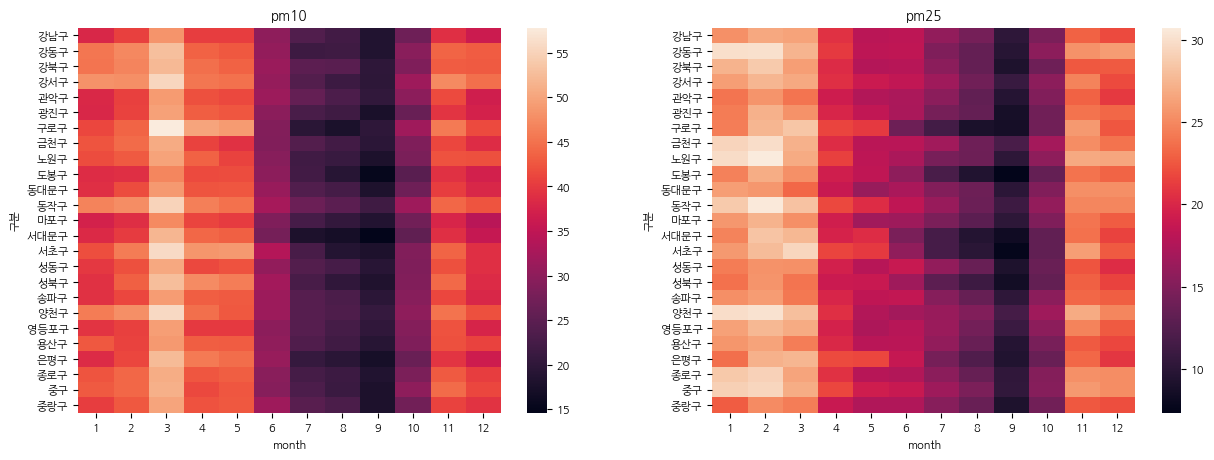

In [18]:
df['hour'] = df['일시'].dt.hour
df['month'] = df['일시'].dt.month

#df2[['구분', 'pm10']].groupby('구분').mean()

df1 = df.groupby(['month','구분'])['pm10'].mean().unstack().T
df2 = df.groupby(['month','구분'])['pm25'].mean().unstack().T

fig,ax = plt.subplots(1,2,figsize=(15,5))

sns.heatmap(df1,ax=ax[0])
sns.heatmap(df2,ax=ax[1])

ax[0].set_title('pm10')
ax[1].set_title('pm25')
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


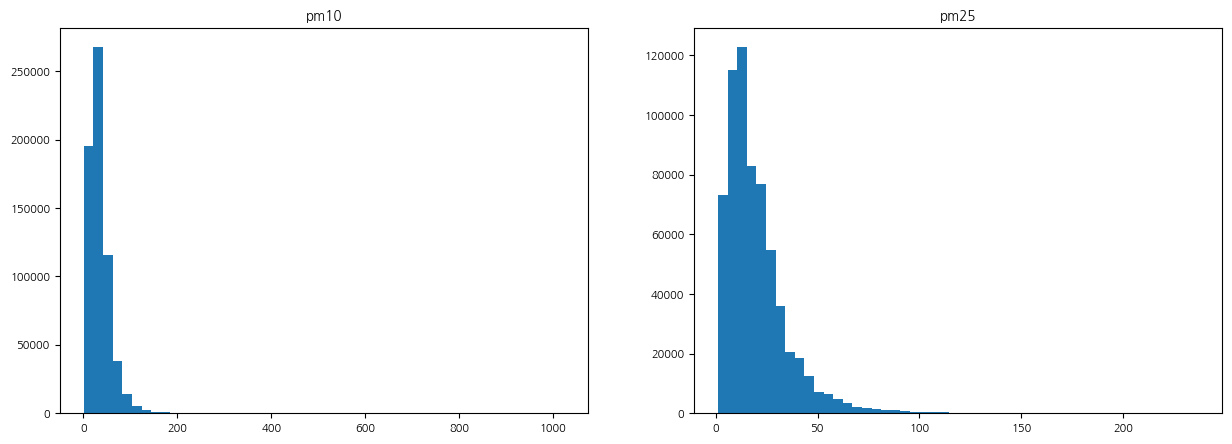

In [19]:
fig,ax = plt.subplots(1,2,figsize=(15,5))

ax[0].hist(df['pm10'], bins = 50)
ax[1].hist(df['pm25'], bins = 50)
ax[0].set_title('pm10')
ax[1].set_title('pm25')
plt.show()

모델링을 위한 데이터 전처리 및 결측치 처리를 시행하라
독립변수는 a일자의 지역구, 각 시간대별 pm10값이며
종속변수는 a+1일자의 00:00시의 해당 지역구의 pm25 값이다
아래는 예시이다.

In [20]:
import datetime

pm10 = df.pivot(index = ['date','구분'], columns = ['hour'] , values = 'pm10').reset_index()
pm10.columns = ['date','구분'] + [str(x) +'시' for x in range(24)]


## 종속변수는 a + 1 00:00시의 해당 지역구
y_df = df[df.hour == 0][['date', '구분','pm25']].reset_index(drop = True)

# a + 1 : TimeDelta
y_df['date']= y_df['date'] - pd.Timedelta(days = 1)


df_total = pd.merge(pm10, y_df, how = 'outer')


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [21]:
# null 값이 3개 이하인 데이터
t = df_total[df_total.isnull().sum(axis = 1) <= 3].reset_index(drop = True)

# pm25가 null 이 아닌 데이터
t = t[t.pm25.notnull()].reset_index(drop = True)

# 결측 확인
#print(t.isnull().sum())

# 시간 부분만 = interplolate 쓰기
t.iloc[:,2:-1] =  t.iloc[:,2:-1].interpolate(axis = 1).fillna(method = 'bfill' , axis = 1)
t.head(10)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,date,구분,0시,1시,2시,3시,4시,5시,6시,7시,8시,9시,10시,11시,12시,13시,14시,15시,16시,17시,18시,19시,20시,21시,22시,23시,pm25
0,2020-01-01,강남구,19.0,32.0,28.0,20.0,20.0,20.0,20.0,21.0,23.0,25.0,24.0,28.0,27.0,31.0,32.0,36.0,36.0,36.0,37.0,39.0,39.0,42.0,41.0,43.0,32.0
1,2020-01-01,강동구,27.0,25.0,25.0,25.0,24.0,28.0,27.0,28.0,29.0,32.0,30.0,31.0,32.0,36.0,39.0,40.0,41.0,42.0,44.0,51.0,50.0,52.0,49.0,51.0,39.0
2,2020-01-01,강북구,21.0,32.0,30.0,33.0,29.0,35.0,32.0,33.0,31.0,31.0,33.0,37.0,40.0,44.0,41.0,45.0,48.0,50.0,50.0,51.0,48.0,50.0,50.0,55.0,35.0
3,2020-01-01,강서구,23.0,29.0,25.0,27.0,27.0,35.0,26.0,30.0,27.0,29.0,32.0,40.0,48.0,41.0,39.0,46.0,45.0,46.0,47.0,51.0,46.0,52.0,47.0,52.0,31.0
4,2020-01-01,관악구,29.0,24.0,24.0,27.0,24.0,27.0,25.0,23.0,24.0,26.0,26.0,27.0,29.0,32.0,36.0,38.0,38.0,41.0,43.0,47.0,49.0,51.0,52.0,51.0,32.0
5,2020-01-01,광진구,23.0,25.0,21.0,23.0,23.0,21.0,24.0,22.0,27.0,23.0,28.0,23.0,33.0,33.0,39.0,33.0,43.0,39.0,46.0,44.0,45.0,45.0,47.0,43.0,29.0
6,2020-01-01,구로구,20.0,16.0,16.0,16.0,16.0,19.0,20.0,22.0,19.0,19.0,27.0,27.0,27.0,29.0,34.0,37.0,37.0,45.0,45.0,47.0,48.0,47.0,47.0,48.0,32.0
7,2020-01-01,금천구,24.0,21.0,19.0,20.0,22.0,20.0,21.0,22.0,22.0,23.0,23.0,26.0,23.0,26.0,32.0,33.0,34.0,38.0,40.0,43.0,43.0,39.0,39.0,44.0,40.0
8,2020-01-01,노원구,22.0,20.0,21.0,23.0,22.0,21.0,21.0,22.0,22.0,21.0,22.0,26.0,25.0,26.0,31.0,31.0,31.0,39.0,33.0,36.0,34.0,37.0,37.0,41.0,33.0
9,2020-01-01,도봉구,21.0,19.0,19.0,27.0,20.0,21.0,23.0,22.0,21.0,23.0,24.0,26.0,31.0,38.0,31.0,31.0,37.0,42.0,41.0,39.0,44.0,43.0,45.0,40.0,28.0


3가지 회귀 분석 모델을 선정하고 선정이유를 설명하라. 각 모델을 kfold 방식을 통해 학습하고 적절한 평가지표를 통해 모델을 평가

In [22]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [23]:
X = t.drop(columns = ['date', '구분','pm25'])
y = t['pm25']


rf = RandomForestRegressor()
dc = DecisionTreeRegressor()
ad = AdaBoostRegressor()

models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Random Forest Regression': RandomForestRegressor(n_estimators=100)
}

# K-Fold 교차 검증
kf = KFold(n_splits = 5, shuffle = True, random_state = 134)

# Model 딕셔너리의 items들
for name, model in models.items() :
  cv_score = cross_val_score(model, X, y, cv= kf , scoring = 'neg_mean_squared_error')
  cv = np.mean(-cv_score)

  print(f"{name} - {-cv}")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Linear Regression - 89.72919760759689
Ridge Regression - 89.72919576092424
Random Forest Regression - 33.76302725793394


In [33]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

kfold = KFold(n_splits=3, shuffle=True, random_state=42)
rmse_rfr, rmse_svr, rmse_xgbr = [],[],[]
for train_index, test_index in kfold.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    rfr = RandomForestRegressor()
    rfr.fit(X_train,y_train)
    pred_rfr = rfr.predict(X_test)
    rmse_rfr.append( np.sqrt(mean_squared_error(y_test,pred_rfr)) )

    svr = SVR()
    svr.fit(X_train,y_train)
    pred_svr = svr.predict(X_test)
    rmse_svr.append( np.sqrt(mean_squared_error(y_test,pred_svr)) )

    xgbr = XGBRegressor()
    xgbr.fit(X_train,y_train)
    pred_xgbr = xgbr.predict(X_test)
    rmse_xgbr.append( np.sqrt(mean_squared_error(y_test,pred_xgbr)) )

rmse_rfr, rmse_svr, rmse_xgbr

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


([5.752578244431342, 5.789035006435094, 6.109928510248582],
 [8.100677820547006, 8.061855419338649, 8.558780826491935],
 [5.762845032745931, 5.917752827842828, 6.228637241163448])

In [41]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
import numpy as np

# 모델 선정 이유
# 1. 선형 회귀: 미세먼지 농도는 시간, 지역에 따라 선형적인 관계를 보일 수 있음.
# 2. 라쏘: 변수 선택 및 모델 정규화를 통해 과적합 방지
# 3. 릿지: 모델 정규화를 통해 과적합 방지

models  = {
    'Linear' : LinearRegression(),
    'Lasso'  : Lasso(),
    'Ridge'  : Ridge()
}

for name, model in models.items() :
  # KF Fold 선정
  kf = KFold(n_splits= 3, shuffle = True, random_state= 1234)
  # score 넣는 리스트
  score = []
  for train_index, test_index in kf.split(X) :
    x_train, x_test = X.iloc[train_index] , X.iloc[test_index]
    y_train, y_test  = y.iloc[train_index] , y.iloc[test_index]
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    score.append(r2_score(y_test, y_pred))

  print(f"{name}")
  print(f"{np.mean(score)}")
  print(f"MSE: {mean_squared_error(y_pred, y_test)}")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Linear
0.6318238878710138
MSE: 83.78568706939107
Lasso
0.6289841367222246
MSE: 83.8597470167338
Ridge
0.6318239008606285
MSE: 83.78567778776996


7번에서 가장 높은 스코어를 가진 모델 하나를 선정하여 최적화 과정을 하려한다. grid search를 통해 모델을 학습하여 성능을 비교

In [51]:
from sklearn.model_selection import GridSearchCV
best_model = 'Ridge'

ridge_param = {
     'alpha': [0.001, 0.01, 0.1, 1, 10],
     'max_iter': [100,200,300]
}

grid = GridSearchCV(Ridge(), ridge_param, cv = 5, scoring = 'r2')
grid.fit(x_train, y_train)

print("Best Parameter :", grid.best_params_)
print("Best Score :" , grid.best_score_)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Best Parameter : {'alpha': 10, 'max_iter': 100}
Best Score : 0.0042641095247941685


지역별 헬스장의 인허가 일자 및 폐업일자에 관한 데이터이다(2025-02-28일에 조사된 데이터라고 가정한다) </br>
수도권(서울,경기도)과 지방(그 외)의 인허가 후 365일 이내 폐업 여부가 연관이 있는지 확인하려한다. </br>
(1) 가설설정 </br>
(2) 통계 검정 </br>

In [60]:
df =pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/mock/002_s1.csv')
df.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,인허가일자,폐업일자,상세영업상태명,소재지전체주소,사업장명
0,2014-09-24,NaN,영업중,대구광역시 달성군 다사읍 죽곡리 808-1번지 2~3층,슬림 휘트니스 클럽
1,2016-05-02,NaN,영업중,대구광역시 달성군 화원읍 구라리 1737-14번지 4층,다짐휘트니스
2,2016-05-09,NaN,영업중,대구광역시 달성군 옥포읍 교항리 2902번지,디젤 피트니스
3,2016-12-13,NaN,영업중,대구광역시 달성군 유가읍 봉리 606 하이젠스타 9층,뷰스 짐
4,2017-01-04,NaN,영업중,대구광역시 달성군 다사읍 세천리 1580-9번지 3층,다짐휘트니스


In [78]:
## 날짜 처리
df['인허가일자'] = pd.to_datetime(df['인허가일자'])

# 폐업일자 - NA : 문제에서 2025-02-28이라고 가정 fillna
df['폐업일자'] = pd.to_datetime(df['폐업일자']).fillna('2025-02-28')

# 도시 추출
df['city'] = df['소재지전체주소'].str.split(' ').str[0]

# 서울, 경기 추출  - 수도권(서울,경기도)과 지방(그 외)의
df['지역'] = df['city'].map(lambda x  :'수도권' if x in ['서울특별시','경기도'] else  '지방')

# 운영일
df['운영일'] = (df['폐업일자'] - df['인허가일자']).dt.days

#  인허가 후 365일 이내 폐업 여부
#df['상세영업상태명'].value_counts() 영업중, 폐업
df['one_year_yn']= df.apply(lambda x : 'yes' if (x['운영일'] <= 365) and (x['상세영업상태명'] == '폐업') else 'no', axis = 1)


# 지역 + 폐업여부
display(pd.crosstab(df['지역'],df['one_year_yn'] ) )

from scipy.stats import chi2_contingency
stat, p, dof, expected = chi2_contingency(pd.crosstab(df['지역'],df['one_year_yn'] ))
print(p)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


one_year_yn,no,yes
지역,,
수도권,10550,232
지방,10506,186


0.03265931875988026


여러 치킨 브랜드의 데이터이다(치킨브랜드는 사업장명에 반드시 대표 브랜드명이 들어가야한다)
2017~ 2022년도에 인허가가 발생한 굽네치킨,교촌치킨,네네치킨,자담치킨 영업장의 시설총규모간의 차이가 브랜드별로 존재하는지 확인하려 한다.
1. ANOVA를 사용 하기 위한 사전 조건들을 확인 하라
2. 적당한 통계 검정을 실시 하고 필요하다면 사후 분석까지 진행하라

In [81]:
df =pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/mock/002_s2.csv')
df.head(5)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,인허가일자,사업장명,업태구분명,시설총규모,업체ID
0,2023-11-24,자담치킨,한식,186.00,ID_0
1,2023-09-27,네네치킨&봉구스밥버거 안동과학대점,호프/통닭,25.00,ID_1
2,2023-10-11,교촌치킨 봉천3호점,기타,72.00,ID_2
3,2019-01-09,맘스터치,분식,38.78,ID_3
4,2022-05-10,노랑통닭,호프/통닭,26.10,ID_4


In [109]:
#df.loc[df['사업장명'].str.contains('자담|굽네|교촌|네네')]
df['인허가일자'] = pd.to_datetime(df['인허가일자'] )


def rename(df) :
  if '자담' in df['사업장명'] :
    return '자담'

  elif '굽네' in df['사업장명'] :
    return '굽네'

  elif '교촌' in df['사업장명'] :
    return '교촌'

  elif '네네' in df['사업장명'] :
    return '네네'

  else :
    return '기타'

df['brand'] = df.apply(rename, axis = 1)

## Filtering Brand
brand_df = df[df['brand'].str.contains('자담|굽네|네네|교촌')]
brand_df.brand.value_counts()

# Filtering 인허가 년도
filter_df = brand_df[brand_df['인허가일자'].dt.year.between(2017,2022)]
filter_df.head(5)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,인허가일자,사업장명,업태구분명,시설총규모,업체ID,brand
8,2021-01-22,자담치킨 초지점,호프/통닭,38.40,ID_8,자담
9,2021-02-01,자담치킨 각산점,기타,38.11,ID_9,자담
11,2021-01-18,자담치킨 관저점,호프/통닭,52.29,ID_11,자담
12,2021-01-19,자담치킨안양호계점,호프/통닭,26.04,ID_12,자담
13,2021-01-25,자담치킨 함안점,호프/통닭,44.91,ID_13,자담


In [127]:
## Anova 수행 조건
# 1) 정규성
import scipy.stats as stats
from scipy.stats import levene

# H0 : 정규분포이다.
d = filter_df.copy()
brand = d['brand'].unique()
brand

for name in brand :
  print(f"{name} 정규성 검정 {stats.shapiro(d[d['brand'] == name]['시설총규모']).pvalue}")


df1 = d[d.brand =='굽네']['시설총규모'].reset_index(drop=True)
df2 = d[d.brand =='교촌']['시설총규모'].reset_index(drop=True)
df3 = d[d.brand =='네네']['시설총규모'].reset_index(drop=True)
df4 = d[d.brand =='자담']['시설총규모'].reset_index(drop=True)


# 2) 등분산 검정
# 귀무 : 등분산이다.
levene(df1, df2, df3, df4)

자담 정규성 검정 2.0305566508405046e-24
교촌 정규성 검정 3.574808753676858e-21
네네 정규성 검정 1.7722785753360861e-12
굽네 정규성 검정 2.0958558526413075e-15


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


LeveneResult(statistic=18.031372925587693, pvalue=1.7405615101408585e-11)

In [132]:
# 정규성과 등분산성을 만족하지 않기 때문에 - Kruskal 검정
# 귀무 가설 : 브랜드별 시설 규모의 차이는 없다.
# 대립 가설 : 브랜드별 시설 규모의 차이는 있다.

from scipy.stats import kruskal
stat, p = kruskal(df1, df2, df3, df4)
print(stat, p)


# 사후분석
from statsmodels.stats.multicomp import pairwise_tukeyhsd

posthoc = pairwise_tukeyhsd(d['시설총규모'], d['brand'], alpha=0.05)
display(posthoc.summary())

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


496.794760111248 2.3620476585292532e-107


group1,group2,meandiff,p-adj,lower,upper,reject
교촌,굽네,-36.3291,0.0,-42.5425,-30.1156,True
교촌,네네,-52.3474,0.0,-60.9126,-43.7822,True
교촌,자담,-46.3661,0.0,-51.7346,-40.9977,True
굽네,네네,-16.0183,0.0,-24.8895,-7.1472,True
굽네,자담,-10.0371,0.0001,-15.8813,-4.1929,True
네네,자담,5.9812,0.249,-2.32,14.2825,False


In [143]:
# 사후분석
#!pip install scikit_posthocs
import scikit_posthocs as sp


brands = d['brand'].unique()
lst = []

for brand in brands :
  brand_data = d[d['brand'] == brand]['시설총규모'].values
  lst.append(brand_data)

p_result = sp.posthoc_dunn(lst , p_adjust  = 'holm')
print(p_result)
print("")
print("각 행과 열은 브랜드를 나타내며, 값은  p-value이다. p-value가 작을 수록 두 그룹간 차이가 통계적으로 유의하다")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


              1             2             3             4
1  1.000000e+00  6.092659e-94  1.690109e-02  3.822313e-09
2  6.092659e-94  1.000000e+00  7.399106e-52  1.373702e-33
3  1.690109e-02  7.399106e-52  1.000000e+00  1.787432e-09
4  3.822313e-09  1.373702e-33  1.787432e-09  1.000000e+00

각 행과 열은 브랜드를 나타내며, 값은  p-value이다. p-value가 작을 수록 두 그룹간 차이가 통계적으로 유의하다


두명의 운동선수가 2번의 경기동안 득점한 결과이다.
1. 두 선수의 실력이 동일 하다 말할 수 있는지 검정하라
2. 오즈비를 구하여라

In [146]:
from scipy.stats import fisher_exact
data = [[10, 2], [3, 6]]
odds , p_val = fisher_exact(data)
print(p_val)

0.03184431667403804


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


출처 : https://vincentarelbundock.github.io/Rdatasets/datasets.html

각 행은 여러 요소들(A,C,E,N,O)의 정량적인 값을 의미한다

1. 요인성분석을 통해 요인분석이 가능한지 확인하라
2. 요인분석을 통해 적정 요인수를 확인하고 탐색적 요인분석을 실시하라

In [149]:
import pandas as pd
df = pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/mock/002_s3.csv')
df.head(5)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,A1,A2,A3,A4,A5,C1,C2,C3,C4,C5,E1,E2,E3,E4,E5,N1,N2,N3,N4,N5,O1,O2,O3,O4,O5,ID
0,2.0,4.0,3.0,4.0,4.0,2.0,3.0,3.0,4.0,4.0,3.0,3.0,3.0,4.0,4.0,3.0,4.0,2.0,2.0,3.0,3.0,6,3.0,4.0,3.0,ID_0
1,2.0,4.0,5.0,2.0,5.0,5.0,4.0,4.0,3.0,4.0,1.0,1.0,6.0,4.0,3.0,3.0,3.0,3.0,5.0,5.0,4.0,2,4.0,3.0,3.0,ID_1
2,5.0,4.0,5.0,4.0,4.0,4.0,5.0,4.0,2.0,5.0,2.0,4.0,4.0,4.0,5.0,4.0,5.0,4.0,2.0,3.0,4.0,2,5.0,5.0,2.0,ID_2
3,4.0,4.0,6.0,5.0,5.0,4.0,4.0,3.0,5.0,5.0,5.0,3.0,4.0,4.0,4.0,2.0,5.0,2.0,4.0,1.0,3.0,3,4.0,3.0,5.0,ID_3
4,2.0,3.0,3.0,4.0,5.0,4.0,4.0,5.0,3.0,2.0,2.0,2.0,5.0,4.0,5.0,2.0,3.0,4.0,4.0,3.0,3.0,3,4.0,3.0,3.0,ID_4


In [152]:
#!pip install factor_analyzer

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.0
[5.13431118 2.75188667 2.14270195 1.85232761 1.54816285 1.07358247
 0.83953893 0.79920618 0.71898919 0.68808879 0.67637336 0.65179984
 0.62325295 0.59656284 0.56309083 0.54330533 0.51451752 0.49450315
 0.48263952 0.448921   0.42336611 0.40067145 0.38780448 0.38185679
 0.26253902]


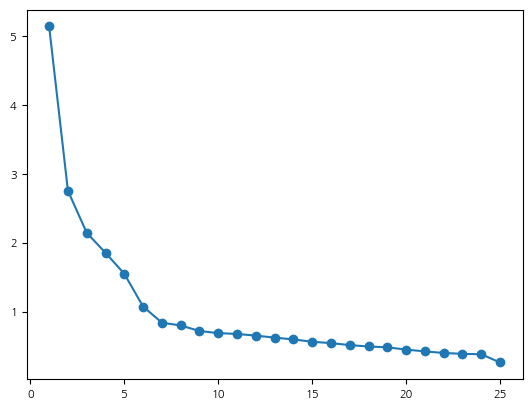

In [162]:
df2 = df.drop('ID', axis = 1)

from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo

# 1) 데이터 세트의 요인성 평가 - bartleet_sphericity 함수로 평가
# 귀무 : 변수간 상관성이 없다
# 대립 : 변수간 상관성이 있다. > 요인 분석 가능
chi_stat, p_val  = calculate_bartlett_sphericity(df2)
print(p_val)

# 2) 요인수 선택 - 몇 개의 요인으로 분석 할지에 대한 eigen_value를 도출한다.
fa = FactorAnalyzer(n_factors = 25, rotation=  None)
fa.fit(df2)
ev, v = fa.get_eigenvalues()
print(ev)

plt.plot(range(1, df2.shape[1] + 1) , ev,  'o-')
# Eigenvalue 가 1 이상일때까지 혹은 그래프가 완만해지기 전까지 : 데이터 결함을 최소화 시킬 수 있음

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: >

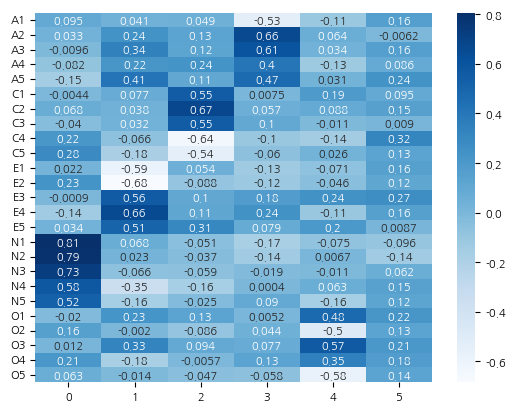

In [166]:
fa1 = FactorAnalyzer(n_factors= 6, rotation = 'varimax')
fa1.fit(df2)

fa_result = pd.DataFrame(fa1.loadings_ , index = df2.columns)
sns.heatmap(fa_result, cmap = "Blues", annot = True)